In [2]:
import pandas   as pd             # dataframe
import seaborn  as sns            # plots
import matplotlib.pyplot as plt   # plots
import yfinance as yf         # import Yahoo! Finance

In [3]:
#AEX ^AEX
#BEL20 ^BFX
#DJIA ^DJI
#S&P500 ^GSPC
#Nikkei ^N225
#MSCI World Index ETF IWDA.AS
indices = {'BEL20':'^BFX','AEX':'^AEX', 'DJIA':'^DJI','S&P500':'^GSPC','Euro Stoxx 50':'^STOXX50E','MSCI World ETF':'SPYI.DE'}
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,2024]


# Dictionary to store the yearly returns
yearly_returns = pd.DataFrame()

#data= yf.download('^AEX', start='2010-01-01', end='2025-10-01')
#data.head



In [4]:
def getfirsttradingdate(year):
        return pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='B').min()

def getlasttradingdate(year):
        return pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='B').max()

In [5]:
# Loop through each index and calculate the yearly returns
for name, ticker in indices.items():
    
    for year in years:
      # Download the data
      data = yf.download(ticker, start=getfirsttradingdate(year), end=getlasttradingdate(year))
      yearly_return = (data["Close"].iloc[-1] / data["Close"].iloc[0]) - 1
      new_row = pd.DataFrame({'Ticker': ticker, 'Year': year, 'Yearly Return': yearly_return})
      yearly_returns = pd.concat([yearly_returns, new_row], ignore_index=True)
 


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [26]:
print(yearly_returns)


      Ticker  Year  Yearly Return (%)  Yearly Return
0       ^BFX  2013          15.905253            NaN
1       ^BFX  2014          13.746462            NaN
2       ^BFX  2015          13.786218            NaN
3       ^BFX  2016          -1.144726            NaN
4       ^BFX  2017           9.141523            NaN
..       ...   ...                ...            ...
211  SPYI.DE  2020                NaN       0.051449
212  SPYI.DE  2021                NaN       0.284200
213  SPYI.DE  2022                NaN      -0.123364
214  SPYI.DE  2023                NaN       0.151489
215  SPYI.DE  2024                NaN       0.229698

[216 rows x 4 columns]


In [7]:
# Create a mapping from ticker to index name
ticker_to_name = {v: k for k, v in indices.items()}

# Add a 'Title' column using the mapping
yearly_returns['Title'] = yearly_returns['Ticker'].map(ticker_to_name)

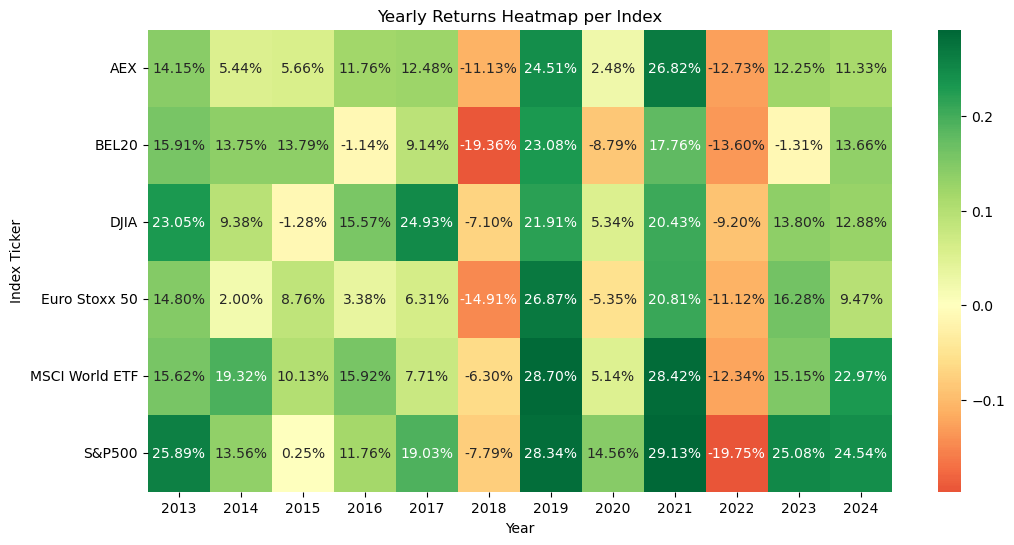

In [ ]:
# Pivot the dataframe to have indices as rows and years as columns
pivot_returns = yearly_returns.pivot(index='Title', columns='Year', values='Yearly Return')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_returns, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title("Yearly Returns Heatmap per Index")
plt.ylabel("Index Name")
plt.xlabel("Year")
plt.show()